# Advanced Text Analysis with SpaCy and Scikit-Learn

This notebook was originally prepared for the workshop [Advanced Text Analysis with SpaCy and Scikit-Learn](http://dhweek.nycdh.org/event/advanced-text-analysis-with-spacy-and-scikit-learn/), presented as part of NYCDH Week 2017. Here, we try out features of the SpaCy library for natural language processing. We also do some statistical analysis using from the scikit-learn library. 

Modifed from [Jonathan Reeve](http://jonreeve.com) ([Group for Experimental Methods in the Humanities](http://xpmethod.plaintext.in/), Columbia University).  

In [6]:
!pip install sent2vec

  Could not find a version that satisfies the requirement sent2vec (from versions: )
No matching distribution found for sent2vec


In [3]:
import spacy
import pandas as pd
import numpy as np
from collections import Counter
from glob import glob
import string
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

# Display plots in this notebook, instead of externally. 
from pylab import rcParams
rcParams['figure.figsize'] = 16, 8
%matplotlib inline

# The following are optional dependencies. 
# Feel free to comment these out. Otherwise you need to pip install them
# Sent2tree uses the sent2tree.py module in this repository. 
from sent2tree import sentenceTree
import ete3 # data visualisation library
import seaborn # data visualisation library

ImportError: cannot import name 'TreeStyle'

In [3]:
# This command might take a little while -> sm/ md
# There are some default library models that are built by spacy. These are either sm (small model with limited features), 
# md (mid model) and lg (large model takes longer to load).
# https://spacy.io/usage/models # you may need to run this
#!python -m spacy download en_core_web_sm  
nlp = spacy.load('en_core_web_sm')

The sample data is the script of the 1975 film _Monty Python and the Holy Grail_, taken from the NLTK Book corpus, and the Project Gutenberg edition of Jane Austen's novel _Pride and Prejudice_. 

In [4]:
grail_raw = open('data/grail.txt',mode='r',encoding='utf-8')
pride_raw = open('data/pride.txt',mode='r',encoding='utf-8')

In [5]:
# Parse the texts. These commands might take a little while. 
grail = nlp(grail_raw.read())
pride = nlp(pride_raw.read())

# Exploring the Document

Each SpaCy document is already tokenized into words, which are accessible by iterating over the document: 

In [6]:
#print (pride[0])
print (pride[1:10])

is a truth universally acknowledged, that a single


You can break up into sentences and iterate over it. `doc.sents` is a generator object, so we can use `next()`: 

In [7]:
next(pride.sents)

﻿It is a truth universally acknowledged, that a single man in possession
of a good fortune, must be in want of a wife.


Or you can force it into a list, and then do things with it: 

In [8]:
prideSents = list(pride.sents)
prideSents[-1] # last sentence

Darcy, as well as Elizabeth, really loved them; and they were both ever
sensible of the warmest gratitude towards the persons who, by bringing
her into Derbyshire, had been the means of uniting them.

In [9]:
list(grail.sents)[-1]

CAMERAMAN: Christ!

For example, let's find the longest sentence(s) in _Pride and Prejudice_: 

In [10]:
prideSentenceLengths = [len(sent) for sent in prideSents]
[sent for sent in prideSents if len(sent) == max(prideSentenceLengths)]

[“I am by no means of the opinion, I assure you,” said he, “that a ball
 of this kind, given by a young man of character, to respectable people,
 can have any evil tendency; and I am so far from objecting to dancing
 myself, that I shall hope to be honoured with the hands of all my fair
 cousins in the course of the evening; and I take this opportunity of
 soliciting yours, Miss Elizabeth, for the two first dances especially,
 a preference which I trust my cousin Jane will attribute to the right
 cause, and not to any disrespect for her.”
 , The idea of Mr. Collins, with all his solemn composure, being run away
 with by his feelings, made Elizabeth so near laughing, that she could
 not use the short pause he allowed in any attempt to stop him further,
 and he continued:
 
 “My reasons for marrying are, first, that I think it a right thing for
 every clergyman in easy circumstances (like myself) to set the example
 of matrimony in his parish; secondly, that I am convinced that it will
 

## Exploring Words

Each token has a crazy number of properties: 

In [11]:
# .i shows the where the word is located
def locations(needle, haystack): 
    """ 
    Make a list of locations, bin those into a histogram, 
    and  put it into a Pandas Series object for analysis
    """
    return pd.Series(np.histogram(
        [word.i for word in haystack 
         if word.text.lower() == needle], bins=50)[0])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001364C27A548>,
      dtype=object)

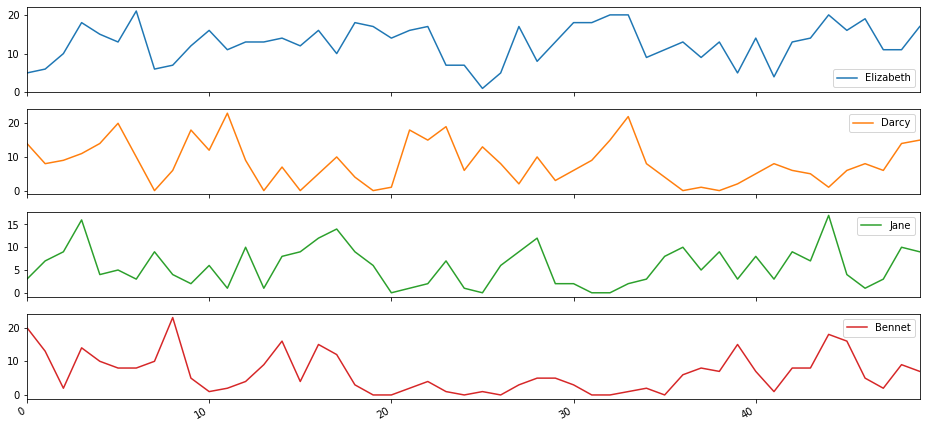

In [12]:
rcParams['figure.figsize'] = 16, 8

pd.DataFrame(
    {name: locations(name.lower(), pride) 
     for name in ['Elizabeth', 'Darcy', 'Jane', 'Bennet']}  # look for where the character names are
).plot(subplots=True)

Looking at the plots, we can then tell which characters tend to appear together in the script.

# Exploring Named Entities

Named entities can be accessed through `doc.ents`. Let's find all the types of named entities from _Monty Python and the Holy Grail_: 

In [13]:
set([w.label_ for w in grail.ents])
# these show the type of entities

{'CARDINAL',
 'DATE',
 'EVENT',
 'FAC',
 'GPE',
 'LANGUAGE',
 'LOC',
 'MONEY',
 'NORP',
 'ORDINAL',
 'ORG',
 'PERSON',
 'PRODUCT',
 'QUANTITY',
 'TIME',
 'WORK_OF_ART'}

What about those that are works of art? 

In [14]:
[ent for ent in grail.ents if ent.label_ == 'PERSON']
# then, it refers back to the original words. Note spacy is smart enough to do n-grams

[Arthur,
 Patsy,
 Ridden,
 Arthur,
 Robinson,
 Arthur,
 Arthur,
 Sorry,
 Dennis,
 Dennis,
 Dennis,
 Arthur,
 Divine Providence,
 Arthur,
 Arthur,
 Aaagh,
 Arthur,
 Ooh,
 Arthur,
 Aagh,
 Arthur,
 Ooh,
 Aaagh,
 Agh,
 Knight,
 Arthur,
 Patsy,
 Knight,
 Hiyaah,
 Thee Lord,
 Knight,
 The Black Knight,
 Patsy,
 MONKS,
 dona eis requiem,
 bonk,
 bonk,
 dona eis requiem,
 bonk,
 bonk,
 dona eis requiem,
 bonk,
 MONKS,
 Burn,
 Burn,
 Burn,
 WITCH,
 Yeaah,
 Ohh,
 Burn,
 Burn,
 Burn,
 Burn,
 Burn,
 Burn,
 Burn,
 Burn,
 Burn,
 Arthur,
 Knight,
 Knight,
 NARRATOR,
 Bedevere,
 Gallahad the Pure,
 Robin,
 Bristol,
 Shh,
 Knights,
 Clark Gable,
 KNIGHTS,
 Arthur,
 Arthur,
 Arthur,
 Behold,
 Arthur,
 Arthur,
 Arthur,
 Arthur,
 King Arthur,
 Guy de Loimbard,
 Jesus Christ,
 KNIGHTS,
 KNIGHTS,
 Run,
 KNIGHTS,
 Run,
 FRENCH,
 FRENCH,
 lapin de bois,
 Quoi,
 Bon,
 Run,
 KNIGHTS,
 Run,
 Run,
 Run,
 Run,
 Run,
 Run,
 Run,
 FRENCH,
 DIRECTOR,
 Arthur,
 Arthur,
 KNIGHT,
 Frank,
 Robin,
 Robin,
 MINSTREL,
 Robi

Place names? 

In [15]:
[ent for ent in grail.ents if ent.label_ == 'GPE']

[England,
 the kingdom of Mercea,
 Huyah,
 Chickennn,
 the Dragon of Angnor,
 England,
 Galahad,
 Galahad,
 Haw,
 Haw,
 ju--,
 Nay,
 us,
 us,
 Bloody,
 This'll,
 Britain,
 he--,
 Galahad,
 Nador,
 Winter,
 um--,
 Holy Grail,
 thine,
 thou,
 France,
 Cornwall,
 Oooohoohohooo]

Organizations? 

In [16]:
set(list([ent.string.strip() for ent in grail.ents if ent.label_ == 'ORG']))

{'ARMY',
 'Arthur',
 'BEDEVERE',
 'BRIDE',
 'Bedevere',
 'Britons',
 'Castle Anthrax',
 'Ewing',
 'Excalibur',
 'GUARD',
 'GUESTS',
 'Grail',
 'HERBERT',
 'HISTORIAN',
 'Hm',
 'Hurry',
 'Huy',
 'INSPECTOR',
 'KNIGHTS',
 'KNIGHTS OF NI',
 'King Arthur',
 "King Arthur's",
 'Launcelot',
 'MAYNARD',
 'NARRATOR',
 'Ohh',
 'Olfin Bedwere of Rheged',
 'Oooo',
 'PATSY',
 'Pie Iesu',
 'ROBIN',
 'Shrubberies',
 'Supreme',
 'Tell',
 'The Holy Hand Grenade of Antioch',
 'The Tale of Sir Launcelot',
 'Thsss',
 'Un',
 'Uther Pendragon',
 'Uuh',
 'VILLAGER',
 'VILLAGERS',
 'Yeaaah',
 'mac',
 'mooo',
 "the BLACK KNIGHT's",
 "the Castle of uuggggggh'",
 'the Court of Camelot',
 'the Gorge of Eternal Peril',
 'the Holy Grail',
 'the Holy Hand Grenade',
 'the Knights of Camelot',
 'the Knights of the Round Table',
 'un cadeau'}

How about groups of people? 

In [17]:
set([ent.string for ent in grail.ents if ent.label_ == 'NORP'])

{'African ',
 'Assyria',
 'European ',
 'French',
 'French ',
 'I. ',
 'Thpppt',
 'orangutans '}

"French" here refers to French _people_, not the French language. We can verify that by getting all the sentences in which this particular type of entity occurs: 

In [18]:
frenchPeople = [ent for ent in grail.ents if ent.label_ == 'NORP' and ent.string.strip() == 'French']
[ent.sent for ent in frenchPeople]

[Well, now, uh, Launcelot, Galahad, and I, uh, wait until nightfall, and then leap out of the rabbit, taking the French, uh, by surprise.  ,
 The ferocity of the French taunting took him completely by surprise, and Arthur became convinced that a new strategy was required if the quest for the Holy Grail were to be brought to a successful conclusion.  ,
 So, we French fellows,
 So, you think you could out-clever us French folk with your silly knees-bent running about advancing behaviour?!  ,
 French persons!]

Let's try on the level of a sentence. First, let's get all the sentences in which Sir Robin is explicitly mentioned: 

In [19]:
robinSents = [sent for sent in grail.sents if 'Sir Robin' in sent.string]
robinSents

[The wise Sir Bedevere was the first to join King Arthur's knights, but other illustrious names were soon to follow: Sir Lancelot the Brave; Sir Gallahad the Pure; and Sir Robin,
 The Tale of Sir Robin.  ,
 Sir Robin rode north, through the dark forest of Ewing, accompanied by his favorite minstrels.,
 [singing] Bravely bold Sir Robin, rode forth from Camelot.  ,
 He was not afraid to die, O brave Sir Robin.  ,
 Brave, brave, brave, brave Sir Robin!  ,
 To have his kneecaps split, and his body burned away, And his limbs all hacked and mangled, brave Sir Robin!,
 He is brave Sir Robin, brave Sir Robin,,
 Brave Sir Robin ran away.,
 Yes, brave Sir Robin turned about,
 [singing] Bravest of the brave, Sir Robin.
 ROBIN: I never
 CARTOON MONKS: [chanting] Pie Iesu domine, dona eis requiem.,
 My liege, it's Sir Robin!
 MINSTREL: [singing] Packing it in and packing it up, And sneaking away and buggering up, And chickening out and pissing off home, Yes, bravely he is throwing in the sponge.,
 

### Analysing one of the sentences

In [20]:
r2 = robinSents[2]
r2

Sir Robin rode north, through the dark forest of Ewing, accompanied by his favorite minstrels.

Let's look at the tags and parts of speech: 

In [21]:
for word in r2: 
    print(word, word.tag_, word.pos_)

Sir NNP PROPN
Robin NNP PROPN
rode VBD VERB
north RB ADV
, , PUNCT
through IN ADP
the DT DET
dark JJ ADJ
forest NN NOUN
of IN ADP
Ewing NNP PROPN
, , PUNCT
accompanied VBN VERB
by IN ADP
his PRP$ DET
favorite JJ ADJ
minstrels NNS NOUN
. . PUNCT

 _SP SPACE


Perform an analysis to determine who are the characters that are 'talking', 'saying', 'doing' the most. Find the relationship between entities and corresponding root verbs

In [22]:
character_verb_counter = Counter()
VERB_LEMMA = 'do'  # say

for ent in pride.ents:
    if ent.label_ == 'PERSON' and ent.root.head.lemma_ == VERB_LEMMA:
        character_verb_counter[ent.text] += 1

print(character_verb_counter.most_common(10)) 
        
# Find all the characters that got married in the book.
#
# Here is an example sentence from which this information could be extracted:
# 
# "her mother was talking to that one person (Lady Lucas) freely,
# openly, and of nothing else but her expectation that Jane would soon
# be married to Mr. Bingley."
#


[('Darcy', 5), ('Bingley', 4), ('Lizzy', 4), ('Elizabeth', 3), ('Gardiner', 3), ('Long', 1), ('William', 1), ('Louisa', 1), ('Lucas', 1), ('Lady Catherine', 1)]


### Available properties in sentence tokens

Let's observe the properties in the sentence r2.

In [23]:
[prop for prop in dir(r2) if not prop.startswith('_')]

['as_doc',
 'conjuncts',
 'doc',
 'end',
 'end_char',
 'ent_id',
 'ent_id_',
 'ents',
 'get_extension',
 'get_lca_matrix',
 'has_extension',
 'has_vector',
 'kb_id',
 'kb_id_',
 'label',
 'label_',
 'lefts',
 'lemma_',
 'lower_',
 'merge',
 'n_lefts',
 'n_rights',
 'noun_chunks',
 'orth_',
 'remove_extension',
 'rights',
 'root',
 'sent',
 'sentiment',
 'set_extension',
 'similarity',
 'start',
 'start_char',
 'string',
 'subtree',
 'tensor',
 'text',
 'text_with_ws',
 'to_array',
 'upper_',
 'vector',
 'vector_norm',
 'vocab']

To drill down into the sentence, we can start with the root of the sentence - from which all the tokens emanate.

In [24]:
r2.root

rode

That root has children: 

In [25]:
list(r2.root.children)

[Robin, north, ,, through, ,, accompanied, .]

Let's see all of the children for each word:  

In [26]:
for word in r2: 
    print(word, ': ', str(list(word.children)))

Sir :  []
Robin :  [Sir]
rode :  [Robin, north, ,, through, ,, accompanied, .]
north :  []
, :  []
through :  [forest]
the :  []
dark :  []
forest :  [the, dark, of]
of :  [Ewing]
Ewing :  []
, :  []
accompanied :  [by]
by :  [minstrels]
his :  []
favorite :  []
minstrels :  [his, favorite]
. :  [
]

 :  []


This is very messy-looking, so let's create a nicer visualization. Here I'll be using a class I wrote called sentenceTree, available in the `sent2tree` module in this repository. It just shoehorns a SpaCy span (sentence or other grammatical fragment) into a tree that can be read by the `ete3` library for handling trees. This library just allows for some pretty visualizations of trees. 

Sir Robin rode north, through the dark forest of Ewing, accompanied by his favorite minstrels.



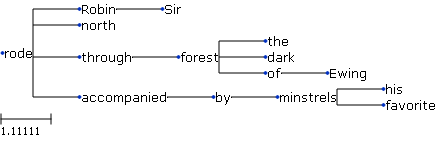

In [27]:
st = sentenceTree(r2)
t, ts = st.render()
t.render('%%inline', tree_style=ts)

You can already see how useful this might be. Since adjectives are typically children of the things they describe, we can get approximations for adjectives that describe characters. How is Sir Robin described iterating through the child words that are adjective.

In [28]:
for sent in robinSents: 
    for word in sent: 
        if 'Robin' in word.string: 
            for child in word.children: 
                if child.pos_ == 'ADJ':
                    print(child)

bold
brave
brave
brave
brave
brave


We need to do it on more sentences in the whole document. Now let's do something similar for Pride and Prejudice. First, we'll use named entity extraction to get a list of the most frequently mentioned characters:  

In [29]:
Counter([w.string.strip() for w in pride.ents if w.label_ == 'PERSON']).most_common(10) 
# Counter is from the Collections library

[('Elizabeth', 623),
 ('Darcy', 399),
 ('Jane', 289),
 ('Bennet', 270),
 ('Bingley', 266),
 ('Collins', 179),
 ('Wickham', 114),
 ('Lizzy', 93),
 ('Gardiner', 91),
 ('Lady Catherine', 87)]

Now we can write a function that walks down the tree from each character, looking for the first adjectives it can find: 

In [30]:
def adjectivesDescribingCharacters(text, character):
    sents = [sent for sent in text.sents if character in sent.string]
    adjectives = []
    for sent in sents: 
        for word in sent: 
            if character in word.string:
                for child in word.children: 
                    if child.pos_ == 'ADJ': 
                        adjectives.append(child.string.strip())
    return Counter(adjectives).most_common(10)

We'll try it on Mr. Darcy: 

In [31]:
adjectivesDescribingCharacters(pride, 'Darcy')

[('late', 6),
 ('present', 2),
 ('delighted', 1),
 ('superior', 1),
 ('abominable', 1),
 ('poor', 1),
 ('little', 1),
 ('disagreeable', 1)]

Now let's do the same sort of thing, but look for associated verbs. First, let's get all the sentences in which Elizabeth is mentioned:  

In [32]:
elizabethSentences = [sent for sent in pride.sents if 'Elizabeth' in sent.string]

And we can peek at one of them: 

In [33]:
elizabethSentences[3]

Mr. Darcy walked off; and Elizabeth
remained with no very cordial feelings toward him.

Mr. Darcy walked off; and Elizabeth
remained with no very cordial feelings toward him.


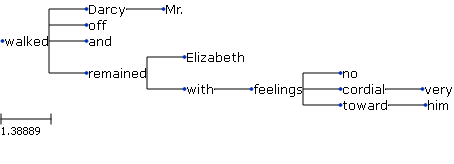

In [34]:
st = sentenceTree(elizabethSentences[3])
t, ts = st.render()
t.render('%%inline', tree_style=ts)

We want the verb associated with Elizabeth, _remained_, not the root verb of the sentence, _walked_, which is associated with Mr. Darcy. So let's write a function that will walk up the dependency tree from a character's name until we get to the first verb. We'll use lemmas instead of the conjugated forms to collapse _remain_, _remains_, and _remained_ into one verb: _remain_. 

In [35]:
def verbsForCharacters(text, character):
    sents = [sent for sent in pride.sents if character in sent.string]
    charWords = []
    for sent in sents: 
        for word in sent: 
            if character in word.string: 
                charWords.append(word)
    charAdjectives = []
    for word in charWords: 
        # Start walking up the list of ancestors 
        # Until we get to the first verb. 
        for ancestor in word.ancestors: 
            if ancestor.pos_.startswith('V'): 
                charAdjectives.append(ancestor.lemma_.strip())
    return Counter(charAdjectives).most_common(20)

In [36]:
elizabethVerbs = verbsForCharacters(pride, 'Elizabeth')
elizabethVerbs

[('say', 65),
 ('cry', 24),
 ('see', 23),
 ('reply', 21),
 ('feel', 19),
 ('make', 18),
 ('look', 15),
 ('take', 11),
 ('receive', 10),
 ('think', 10),
 ('listen', 9),
 ('begin', 9),
 ('walk', 8),
 ('pass', 8),
 ('help', 8),
 ('find', 8),
 ('go', 8),
 ('turn', 7),
 ('ask', 7),
 ('smile', 7)]

In [37]:
darcyVerbs = verbsForCharacters(pride, 'Darcy')
janeVerbs = verbsForCharacters(pride, 'Jane')

We can now merge these counts into a single table, and then we can visualize it with Pandas. 

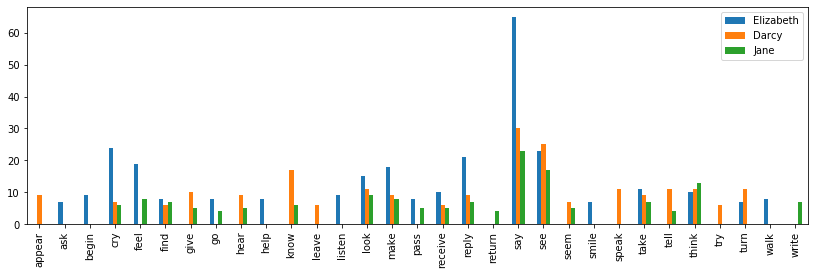

In [38]:
def verbsToMatrix(verbCounts): 
    """ 
    Takes verb counts given by verbsForCharacters 
    and makes Pandas Series out of them, suitabe for combination in 
    a DataFrame. 
    """
    return pd.Series({t[0]: t[1] for t in verbCounts})

verbsDF = pd.DataFrame({'Elizabeth': verbsToMatrix(elizabethVerbs), 
                        'Darcy': verbsToMatrix(darcyVerbs), 
                        'Jane': verbsToMatrix(janeVerbs)}).fillna(0)
verbsDF.plot(kind='bar', figsize=(14,4))

# Probabilities

SpaCy has a list of probabilities for English words, and these probabilities are automatically associated with each word once we parse the document. Let's see what the distribution is like: 

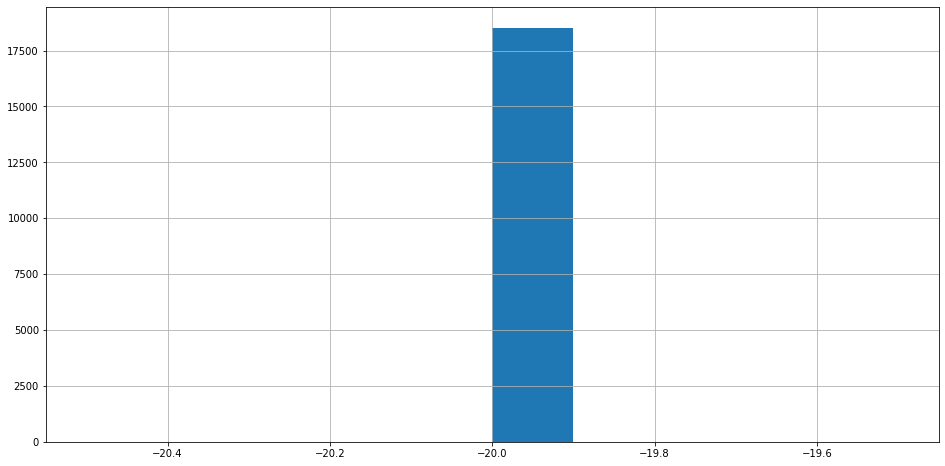

In [39]:
probabilities = [word.prob for word in grail] 
pd.Series(probabilities).hist()

Let's peek at some of the improbable words for _Monty Python and the Holy Grail_. 

In [40]:
list(set([word.string.strip().lower() for word in grail if word.prob < -19]))[:20]

['',
 'forest',
 'again',
 'camaaaaaargue',
 'kills',
 'riding',
 '#',
 'cheesy',
 'own',
 'mate',
 'wom',
 'wound',
 'dangerous',
 'treat',
 'conclusion',
 'biters',
 'rheged',
 'hell',
 'assist',
 'that--']

Now we can do some rudimentary information extraction by counting the improbable words: 

In [41]:
Counter([word.string.strip().lower() 
         for word in grail 
         if word.prob < -19.5]).most_common(20)

[('', 2006),
 (':', 1197),
 ('.', 839),
 ('!', 830),
 (',', 743),
 ('the', 332),
 ('[', 320),
 (']', 320),
 ('you', 263),
 ('arthur', 261),
 ('i', 240),
 ('a', 233),
 ('?', 223),
 ('and', 184),
 ('of', 176),
 ('to', 151),
 ("'s", 142),
 ('it', 141),
 ('no', 129),
 ('#', 127)]

What are those words for _Pride and Prejudice_? 

In [42]:
Counter([word.string.strip().lower() 
         for word in pride 
         if word.prob < -19.5 
         and word.is_alpha
         and word.pos_ != 'PROPN'] # This time, let's ignore proper nouns.
       ).most_common(20)

[('the', 4331),
 ('to', 4160),
 ('of', 3609),
 ('and', 3579),
 ('her', 2224),
 ('i', 2065),
 ('a', 1954),
 ('in', 1880),
 ('was', 1846),
 ('she', 1708),
 ('that', 1576),
 ('not', 1540),
 ('it', 1531),
 ('you', 1357),
 ('he', 1333),
 ('his', 1271),
 ('be', 1240),
 ('as', 1181),
 ('had', 1177),
 ('for', 1058)]

We can do this with ngrams, too, with some fancy Python magic:

In [43]:
def ngrams(doc, n): 
    doc = [word for word in doc 
           if word.is_alpha # Get rid of punctuation
           if not word.string.isupper()] # Get rid of all-caps speaker headings
    return list(zip(*[doc[i:] for i in range(n)]))

In [44]:
grailGrams = set(ngrams(grail, 2))

In [45]:
for gram in grailGrams: 
     if sum([word.prob for word in gram]) < -20: 
         print(gram)

(in, the)
(do, us)
(Launcelot, angels)
(count, thou)
(the, questions)
(me, these)
(and, tell)
(this, lot)
(whop, clunk)
(This, can)
(last, words)
(moistened, bint)
(Jesus, Christ)
(It, reads)
(and, the)
(please, Lie)
(squeak, Ooh)
(Herbert, has)
(they, put)
(any, of)
(do, doubt)
(Gable, It)
(bunny, is)
(What, He)
(silly, English)
(Ni, Who)
(leap, out)
(castle, with)
(Grenade, of)
(seek, the)
(be, long)
(is, your)
(yet, these)
(bowels, unplugged)
(Agh, No)
(Oh, haw)
(said, the)
(Oh, Um)
(you, become)
(them, here)
(they, have)
(foul, cruel)
(Look, There)
(it, said)
(you, mean)
(Get, on)
(come, and)
(handed, Yes)
(Good, Steady)
(but, let)
(all, this)
(like, her)
(thonk, Um)
(your, worst)
(and, giggle)
(heard, nothing)
(back, Come)
(progress, with)
(King, of)
(lot, of)
(of, other)
(be, avenged)
(with, Back)
(thanks, very)
(You, liar)
(accompanied, by)
(And, so)
(of, Arimathea)
(brave, knights)
(witch, We)
(name, Bedevere)
(day, lad)
(pause, they)
(Launcelot, Launcelot)
(out, Once)
(you, as

(occasion, Let)
(it, again)
(Good, luck)
(sir, later)
(me, they)
(Uh, he)
(example, in)
(shall, watch)
(you, a)
(the, Tall)
(up, Stop)
(you, uh)
(He, going)
(a, witch)
(into, a)
(shaped, beacon)
(are, the)
(accomplished, a)
(eat, Robin)
(pweeng, boom)
(Arthur, music)
(Arthur, music)
(King, of)
(up, like)
(here, squeak)
(Hmm, boom)
(burned, off)
(the, first)
(you, You)
(new, strategy)
(been, imprisoned)
(squeak, squeak)
(and, face)
(to, tell)
(that, word)
(approaching, any)
(are, We)
(Huyah, clang)
(along, Everything)
(Schools, take)
(Hurry, Sir)
(large, Skip)
(his, that)
(am, king)
(Allo, dappy)
(one, more)
(that, what)
(liege, Good)
(much, That)
(varletesses, The)
(question, of)
(and, we)
(Ow, Ow)
(to, which)
(you, do)
(What, is)
(just, keep)
(it, Yes)
(bicker, and)
(your, every)
(bit, bit)
(and, see)
(be, nice)
(keep, him)
(No, Knights)
(clank, have)
(The, Black)
(stops, Aaagh)
(Good, idea)
(that, suit)
(clop, clop)
(What, object)
(do, want)
(listen, to)
(last, minute)
(Black, Beast)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(yes, Let)
(are, tired)
(her, as)
(of, Bristol)
(The, oral)
(back, into)
(bats, and)
(Run, away)
(if, you)
(Use, this)
(Oooh, ptoo)
(Camelot, pause)
(note, have)
(that, castle)
(but, other)
(what, do)
(for, our)
(who, hear)
(there, must)
(really, did)
(witness, the)
(going, to)
(know, so)
(sad, So)
(islands, But)
(her, He)
(Are, you)
(then, proceed)
(ha, Charge)
(ni, You)
(minute, How)
(on, with)
(build, a)
(Ooh, All)
(away, Run)
(be, a)
(well, actually)
(Speak, to)
(the, middle)
(Knights, of)
(for, death)
(There, no)
(always, triumphs)
(large, wooden)
(his, feet)
(four, really)
(splat, crying)
(relax, Are)
(under, the)
(anyway, Right)
(Anthrax, The)
(up, Well)
(already, got)
(Mine, is)
(is, your)
(ha, we)
(Oh, wicked)
(Oh, let)
(Sir, Gallahad)
(We, will)
(excepting, that)
(questions, Three)
(chorus, scenes)
(can, not)
(Yes, think)
(mean, An)
(Britons, to)
(head, he)
(in, that)
(sink, in)
(kicked, the)
(busy, man)
(tell, us)
(mean, just)
(to, Twenty)
(the, Grail)
(shall, attack)
(Pie, 

(Look, my)
(to, the)
(then, French)
(music, stops)
(Bravely, bold)
(ha, ha)
(Shh, Shh)
(Ni, Therefore)
(clear, Hic)
(under, considerable)
(Castle, of)
(an, offensive)
(Blue, No)
(we, tell)
(the, oral)
(silly, person)
(snows, of)
(up, Oh)
(to, be)
(a, the)
(chanting, Pie)
(Well, this)
(No, no)
(beat, a)
(witch, chanting)
(Camelot, But)
(for, your)
(do, suppose)
(for, no)
(dance, when)
(he, leave)
(feel, much)
(weather, The)
(that, Rather)
(a, horse)
(your, king)
(Bedevere, was)
(about, who)
(right, Please)
(carp, and)
(it, say)
(my, pimples)
(In, the)
(chord, Not)
(go, too)
(a, task)
(We, do)
(you, shall)
(and, have)
(very, much)
(understand, my)
(enchanter, By)
(other, people)
(No, no)
(nasty, big)
(Ni, Ni)
(Grail, Look)
(Arthur, and)
(dead, clang)
(of, wood)
(the, bride)
(squeak, creak)
(farcical, aquatic)
(bladders, may)
(to, um)
(getting, married)
(There, are)
(the, same)
(this, one)
(donkey, bottom)
(ptoo, Ha)
(never, pass)
(Round, Table)
(this, idiom)
(command, you)
(clang, Bring)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




(er, the)
(nearer, the)
(was, an)
(false, one)
(You, do)
(All, right)
(most, foul)
(at, you)
(If, you)
(was, a)
(considerable, economic)
(strength, come)
(seek, this)
(giggle, giggle)
(get, the)
(nothing, nothing)
(Burn, Who)
(one, Oh)
(of, wood)
(Please, We)
(test, What)
(that, castle)
(the, dark)
(if, you)
(The, Castle)
(wood, Good)
(That, is)
(not, open)
(Oh, had)
(Oh, do)
(cough, Nu)
(illustrious, names)
(this, period)
(clop, Wait)
(just, and)
(Arthur, music)
(a, minute)
(this, lot)
(hee, ha)
(much, peril)
(Beast, of)
(may, cross)
(this, sacred)
(commune, We)
(Well, that)
(mystic, runes)
(since, the)
(music, stops)
(come, Look)
(No, problems)
(Hill, and)
(here, until)
(cave, Tim)
(me, in)
(Victory, is)
(is, a)
(am, a)
(Oh, bloody)
(to, tell)
(the, number)
(shrubbery, One)
(King, Arthur)
(bells, Hah)
(Christ, warned)
(the, union)
(it, thou)
(which, have)
(Now, go)
(silly, king)
(will, to)
(stops, boom)
(In, twenty)
(witches, More)
(Heh, heh)
(through, this)
(have, seen)
(upon, this

(the, boys)
(your, dead)
(saw, saw)
(his, only)
(Hello, He)
(What, a)
(longer, the)
(We, shall)
(music, And)
(that, France)
(you, ca)
(of, the)
(lie, strewn)
(Augh, Ohh)
(tell, you)
(he, think)
(the, swamp)
(the, most)
(she, is)
(You, only)
(think, so)
(Eternal, Peril)
(you, good)
(to, be)
(to, his)
(was, saved)
(Let, me)
(fortune, Well)
(kick, Eh)
(Heh, heh)
(that, no)
(bless, this)
(let, not)
(daughter, to)
(thud, thud)
(about, Did)
(late, dramatic)
(Oh, come)
(carried, it)
(king, thought)
(forest, of)
(quite, dead)
(Old, woman)
(Yes, have)
(a, strange)
(you, gay)
(a, drink)
(upon, the)
(saw, saw)
(splat, In)
(rabbit, It)
(Did, you)
(limbs, all)
(No, it)
(executive, officer)
(Let, us)
(averting, my)
(One, that)
(and, get)
(How, you)
(shimmering, samite)
(at, you)
(first, time)
(afraid, when)
(He, going)
(was, looking)
(It, is)
(Who, does)
(Round, Table)
(protect, us)
(seen, it)
(leave, the)
(the, Castle)
(Back, with)
(handed, No)
(haw, heh)
(for, the)
(right, sonny)
(shalt, thou)
(ha

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




(the, throat)
(not, stop)
(Come, on)
(it, by)
(am, a)
(away, And)
(violence, inherent)
(shrubberies, are)
(cut, down)
(brained, wipers)
(Come, along)
(Yes, Yeah)
(fought, the)
(worried, when)
(Aaaugh, Aaaugh)
(you, Camelot)
(you, must)
(you, do)
(go, bringing)
(it, you)
(this, room)
(boom, boom)
(we, lose)
(So, be)
(at, the)
(the, people)
(of, the)
(Charge, Charge)
(sir, Yeah)
(that, all)
(found, the)
(it, is)
(now, remain)
(uh, anything)
(Launcelot, Hurry)
(lived, Bones)
(Sir, Robin)
(could, talk)
(all, right)
(duck, she)
(a, Well)
(of, Death)
(put, me)
(got, two)
(is, the)
(was, not)
(Just, me)
(place, it)
(Do, you)
(Run, along)
(kill, him)
(your, sword)
(Uh, but)
(that, singing)
(the, Court)
(fine, Come)
(vain, Uh)
(dead, Here)
(lies, a)
(you, tiny)
(ha, ha)
(saw, saw)
(like, an)
(bird, could)
(leave, the)
(Run, awaaaaay)
(we, shall)
(clop, rewr)
(we, see)
(Defeat, at)
(for, it)
(You, silly)
(the, Holy)
(down, the)
(water, clank)
(of, executive)
(clop, You)
(room, No)
(language, is

# Word Embeddings (Word Vectors)

Word embeddings (word vectors) are numeric representations of words, usually generated via dimensionality reduction on a word cooccurrence matrix for a large corpus. The vectors SpaCy uses are the [GloVe](http://nlp.stanford.edu/projects/glove/) vectors, Stanford's Global Vectors for Word Representation. These vectors can be used to calculate semantic similarity between words and documents.

Let's look at vectors for _Pride and Prejudice_. First, let's get the first 150 nouns:

In [46]:
prideNouns = [word for word in pride if word.pos_.startswith('N')][:150]

In [47]:
prideNouns

[﻿It,
 truth,
 man,
 possession,
 fortune,
 want,
 wife,
 feelings,
 views,
 man,
 neighbourhood,
 truth,
 minds,
 families,
 property,
 one,
 daughters,
 lady,
 one,
 day,
 answer,
 wife,
 objection,
 invitation,
 dear,
 man,
 fortune,
 north,
 chaise,
 four,
 place,
 possession,
 servants,
 house,
 end,
 week,
 name,
 dear,
 man,
 fortune,
 four,
 five,
 thousand,
 year,
 thing,
 girls,
 wife,
 one,
 design,
 Design,
 Nonsense,
 love,
 one,
 occasion,
 girls,
 dear,
 share,
 beauty,
 woman,
 five,
 daughters,
 thinking,
 beauty,
 cases,
 woman,
 beauty,
 dear,
 neighbourhood,
 daughters,
 establishment,
 one,
 account,
 newcomers,
 lines,
 consent,
 marrying,
 girls,
 word,
 thing,
 bit,
 others,
 half,
 preference,
 none,
 girls,
 quickness,
 sisters,
 children,
 way,
 delight,
 compassion,
 nerves,
 dear,
 respect,
 nerves,
 friends,
 consideration,
 twenty,
 years,
 men,
 four,
 thousand,
 year,
 neighbourhood,
 use,
 twenty,
 dear,
 twenty,
 mixture,
 parts,
 humour,
 reserve,
 c

Now let's get vectors and labels for each of them: 

In [48]:
prideNounVecs = [word.vector for word in prideNouns]
prideNounLabels = [word.string.strip() for word in prideNouns]

In [49]:
print (prideNounVecs[0])

[-1.4152594   0.45971322 -0.9178735   2.7397466   4.1198945  -2.472838
 -0.57143956  1.5299594   4.415185    3.9129422  -0.03801548  3.6013741
  1.3036608   0.0369436  -3.7250876  -1.0370327  -1.2157063   1.0435308
 -0.6208026  -0.8350083   2.8902025   1.922413    0.15259613 -1.0805628
 -1.89551    -1.2068835   0.827456   -1.1236258  -0.9814154  -0.765808
  1.3754084   0.31375355 -2.2977557  -4.169454    3.4417782  -2.0211
  3.7276583  -0.5868722  -3.5954812   3.6312985   3.988275    2.6913078
 -0.08166742 -5.605893    2.847681    3.973717   -0.17512983  1.0985993
 -1.7482393   3.2569914   2.417911   -0.82431525 -2.8261254   1.6035402
 -3.271429    3.689102    1.7419379  -0.74784863  1.4309633   0.47724903
 -0.60304785  1.6114899   0.08969769  2.3144832   4.94882     0.2546028
 -0.958599   -4.245271   -1.2402717   1.1358163  -0.6716312  -0.26478443
  1.4553194   0.75391597 -2.6361995  -0.28911164  2.161076   -4.5754786
 -3.8752236  -1.4662546   0.15692109 -0.5268869  -3.6577156  -0.488

In [50]:
prideNounVecs[0].shape

(96,)

A single vector is 96-dimensional, so in order to plot it in 2D, it might help to reduce the dimensionality to the most meaningful dimensions. We can use Scikit-Learn to perform truncated singular value decomposition for latent semantic analysis (LSA). 

In [51]:
lsa = TruncatedSVD(n_components=2)   # sklearn.decomposition n =2 for 2D
lsaOut = lsa.fit_transform(prideNounVecs)

Plot the results in a scatter plot. The results how words and how similar they are.

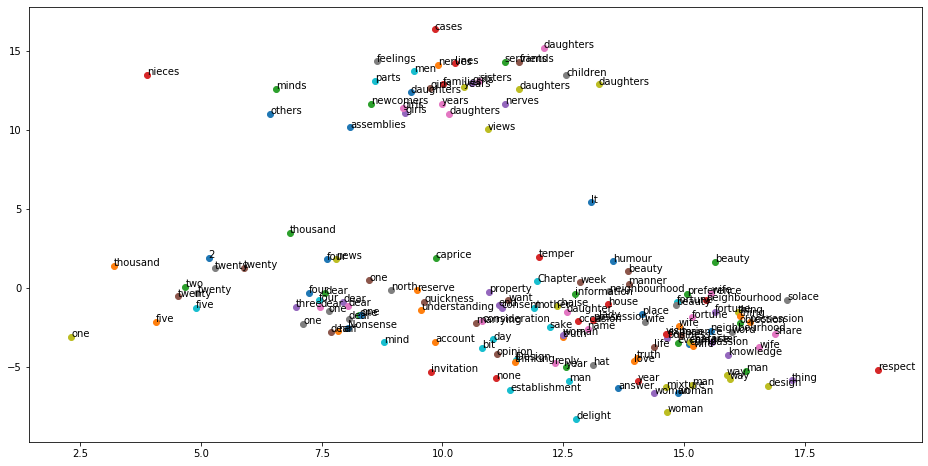

In [52]:
rcParams['figure.figsize'] = 16, 8
xs, ys = lsaOut[:,0], lsaOut[:,1]
for i in range(len(xs)): 
    plt.scatter(xs[i], ys[i])
    plt.annotate(prideNounLabels[i], (xs[i], ys[i]))

# Document Vectorization

This uses a non-semantic technique for vectorizing documents, just using bag-of-words. We won't need any of the fancy features of SpaCy for this, just scikit-learn. We'll use a subset of the Inaugural Address Corpus that contains 20th and 21st century inaugural addresses of the US Presidents. These are in the folder 'inaugural'.

First, we'll vectorize the corpus using scikit-learn's `TfidfVectorizer` class - covered in Text Mining and will also be revised in Day 2 briefly. This creates a matrix of word frequencies. (It doesn't actually use TF-IDF, since we're turning that off in the options below.)

In [53]:
# Let's build a corpus out of the 50 sentences in pride
# Do some cleaning first
from spacy.lang.en.stop_words import STOP_WORDS
stop_words = STOP_WORDS
prideSents = list(grail.sents)[0:1000]
prideSents = [sent for sent in prideSents if len(sent)!=1]
prideSents = [sent.text.translate(str.maketrans('', '', string.punctuation)) for sent in prideSents]

tfidf = TfidfVectorizer(prideSents, decode_error='ignore', stop_words = stop_words, use_idf=False)
#from sklearn.feature_extraction.text import get_feature_names
tfidf

TfidfVectorizer(analyzer='word', binary=False, decode_error='ignore',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input=['SCENE 1', 'wind clop clop clop \n', 'KING ARTHUR',
                       'Whoa there  ', 'clop clop clop \n', 'SOLDIER 1 Halt  ',
                       'Who goes there\n', 'ARTHUR',
                       'It is I Arthur son of Uther Pendragon from the castle '
                       'of Camelot  ',
                       'King of the Britons defeator of the Saxons sovereign '
                       'of all England\...
                stop_words={"'d", "'ll", "'m", "'re", "'s", "'ve", 'a', 'about',
                            'above', 'across', 'after', 'afterwards', 'again',
                            'against', 'all', 'almost', 'alone', 'along',
                            'already', 'also', 'although', 'always', 'am',
                            'among', 'amongst', 'amount', 'an', 'and',
                            'another

In [54]:
inauguralFilenames = sorted(glob('inaugural/*'))

# Make labels by removing the directory name and .txt extension: 
labels = [filename.split('\\')[1] for filename in inauguralFilenames]  # for windows use \\
labels = [filename.split('.')[0] for filename in labels]
print (labels)

# While we're at it, let's make a list of the lengths (no of words, so we can use them to plot dot sizes. 
lengths = [len(open(filename, errors='ignore').read())/100 for filename in inauguralFilenames]  
print(lengths)


['1901-McKinley', '1905-Roosevelt', '1909-Taft', '1913-Wilson', '1917-Wilson', '1921-Harding', '1925-Coolidge', '1929-Hoover', '1933-Roosevelt', '1937-Roosevelt', '1941-Roosevelt', '1945-Roosevelt', '1949-Truman', '1953-Eisenhower', '1957-Eisenhower', '1961-Kennedy', '1965-Johnson', '1969-Nixon', '1973-Nixon', '1977-Carter', '1981-Reagan', '1985-Reagan', '1989-Bush', '1993-Clinton', '1997-Clinton', '2001-Bush', '2005-Bush', '2009-Obama', '2017-Trump']
[134.08, 55.68, 321.64, 95.63, 83.95, 202.98, 239.49, 217.64, 109.03, 106.07, 75.71, 30.39, 136.79, 139.55, 91.9, 76.18, 81.93, 116.24, 99.91, 68.73, 137.35, 145.61, 125.23, 91.14, 122.5, 90.53, 120.18, 134.39, 83.47]


In [55]:
tfidfOut = tfidf.fit_transform(inauguralFilenames)
# convert each of the docs in inauguralFilenames to tf-idf matrix

C:\Users\isstyc\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [56]:
tfidfOut.shape  # no of documents and no of features fitted to the original training corpus

(29, 49)

In [57]:
lsaOut = lsa.fit_transform(tfidfOut.todense())   # todense - how you store the matrices in memory
# lsa converts each of the term-document matrix into 2D by SVD (will be learnt in day 2)

29
1901-McKinley 0.7109347056559997 -0.07558922004586842
1905-Roosevelt 0.7623805625470766 0.46500577967607354
1909-Taft 0.7109347046686035 -0.07483691866497968
1913-Wilson 0.7231340746242488 -0.10722438733981982
1917-Wilson 0.7231340747623357 -0.10715003241027467
1921-Harding 0.7109347002595746 -0.07646843331287867
1925-Coolidge 0.7109346992885236 -0.07862429941448415
1929-Hoover 0.7109347059876527 -0.07506981950285527
1933-Roosevelt 0.7623805624822478 0.4649935776184532
1937-Roosevelt 0.7623805624849824 0.46500029335428006
1941-Roosevelt 0.7623805625095152 0.46499449606511667
1945-Roosevelt 0.7623805625703245 0.4649850039422481
1949-Truman 0.7109347020454592 -0.07649653830492326
1953-Eisenhower 0.7231340738594326 -0.10779807670947689
1957-Eisenhower 0.7231340739019358 -0.10780500652667736
1961-Kennedy 0.710934702749258 -0.07771790619485273
1965-Johnson 0.7109347027321135 -0.07526146884613978
1969-Nixon 0.7231340747576761 -0.10692928244339335
1973-Nixon 0.7231340747581781 -0.106920654

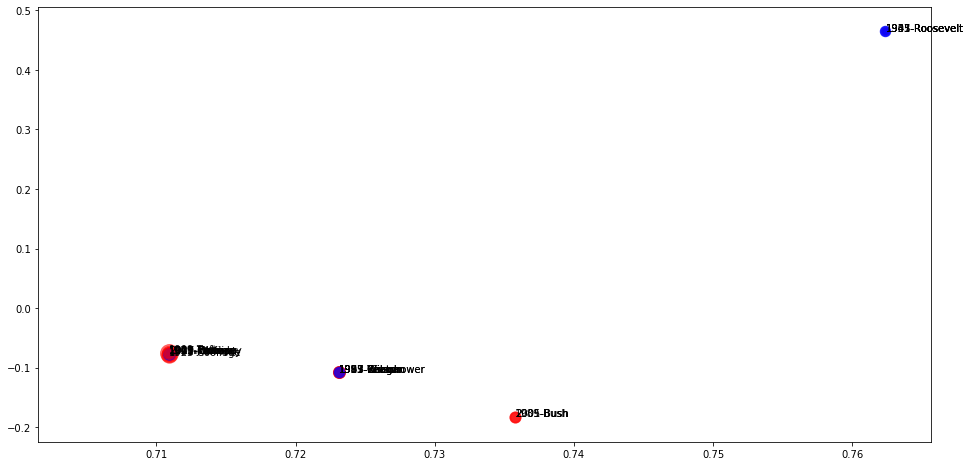

In [58]:
rcParams['figure.figsize'] = 16, 8
# Add a manually compiled list of presidential party affiliations, 
# So that we can use this to color our dots. 
parties = 'rrrbbrrrbbbbbrrbbrrbrrrbbrrrr'
print (len(parties))
xs, ys = lsaOut[:,0], lsaOut[:,1]
for i in range(len(xs)): 
    try:
        plt.scatter(xs[i], ys[i], c=parties[i], s=lengths[i], alpha=0.5)
    except IndexError:
        continue
        
    plt.annotate(labels[i], (xs[i], ys[i]))
    print(labels[i], xs[i], ys[i])  # 

# Document Similarity Matrix

Using the `.similarity()` method from earlier that uses word vectors, we can very easily compute the document similarity between all the inaugural speeches amongst the Presidents.

In [59]:
docs = [nlp(open(filename, errors='ignore').read()) for filename in inauguralFilenames]  

import warnings
warnings.filterwarnings('ignore')
similarities = [ [doc.similarity(other) for other in docs] for doc in docs ]
similaritiesDf = pd.DataFrame(similarities, columns=labels, index=labels)

In [60]:
docs[0]

My fellow-citizens, when we assembled here on the 4th of March, 1897, there was great anxiety with regard to our currency and credit. None exists now. Then our Treasury receipts were inadequate to meet the current obligations of the Government. Now they are sufficient for all public needs, and we have a surplus instead of a deficit. Then I felt constrained to convene the Congress in extraordinary session to devise revenues to pay the ordinary expenses of the Government. Now I have the satisfaction to announce that the Congress just closed has reduced taxation in the sum of $41,000,000. Then there was deep solicitude because of the long depression in our manufacturing, mining, agricultural, and mercantile industries and the consequent distress of our laboring population. Now every avenue of production is crowded with activity, labor is well employed, and American products find good markets at home and abroad.

Our diversified productions, however, are increasing in such unprecedented vo

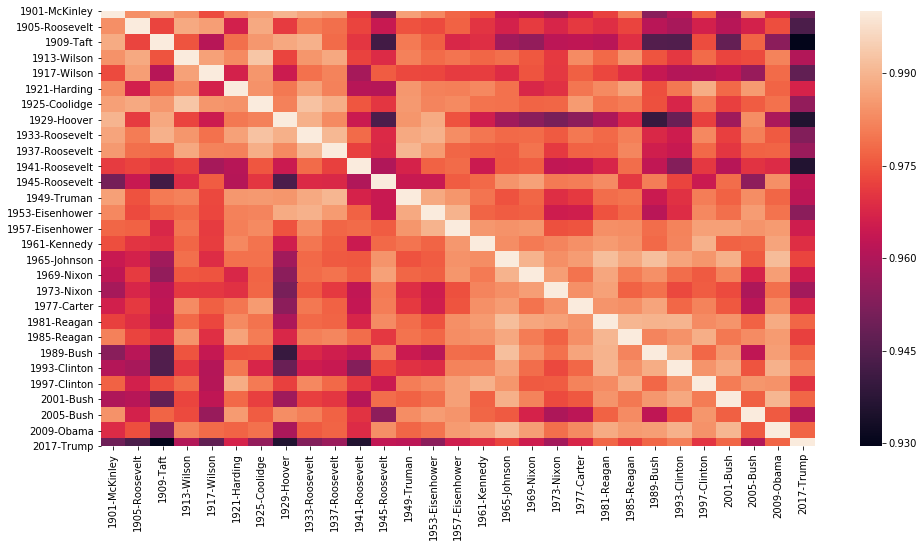

In [61]:
# Requires the Seaborn library. 
rcParams['figure.figsize'] = 16, 8
seaborn.heatmap(similaritiesDf)

# Exercises (optional)

1. Extract all the events from _Pride and Prejudice_. (hint: look for the associated entity with events)
2. Find the shortest sentence in any inaugural address from our corpus.
3. Find the president that used the lowest proportions of adjectives (or nouns, verbs) in his inaugural address.
4. Find which of Charles Dickens's novels (or those of any other author) are the most semantically similar. 
The list of books may be found in https://www.gutenberg.org/
 
# See Also

 - [Textacy, higher-level NLP based on SpaCy](https://github.com/chartbeat-labs/textacy)